# Aplicando métodos ensemble no dataset do facebook

Neste notebook irei aplicar os modelos SVM, KNN, Decision trees, random forests, AdaBoost, gradientBoosting, XGBoosting, bagging, stacking, voting.

### Importação das bibliotecas

In [124]:
#Bibliotecas básicas
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import time

#modelos de machine learning
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor as KNR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, StackingRegressor, VotingRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

### Carregando dados do facebook
Prevendo fechamento das ações baseado no fechamento dos 5 dias anteriores

In [2]:
import pandas_datareader.data as web
import datetime as dt

end = dt.datetime(2020, 1, 1)
start = dt.datetime(2018, 1, 1)

df = web.DataReader("FB", 'yahoo', start, end)

df = df.reset_index()
df = df.drop(columns=['Open','Date','High','Low','Volume','Adj Close'])
df = df.rename(columns={'Close': 'Close 0'})

df.head()

,Close 0
0,181.419998
1,184.669998
2,184.330002
3,186.850006
4,188.279999


In [3]:
#criando 5 janelas

def window (df, w):
    for i in range(1,w):
        df['Close '+str(i)] = df['Close '+str(i-1)].shift(1)
    return df
        
df = window(df,6)
df = df.rename(columns={'Close 0': 'Target'})
df.dropna(inplace=True)
df.head()

,Target,Close 1,Close 2,Close 3,Close 4,Close 5
5,187.869995,188.279999,186.850006,184.330002,184.669998,181.419998
6,187.839996,187.869995,188.279999,186.850006,184.330002,184.669998
7,187.770004,187.839996,187.869995,188.279999,186.850006,184.330002
8,179.369995,187.770004,187.839996,187.869995,188.279999,186.850006
9,178.389999,179.369995,187.770004,187.839996,187.869995,188.279999


In [4]:
# Separando variável alvo e os dados de treino e teste
X = df.loc[:,['Close 1','Close 2','Close 3','Close 4','Close 5']]
y = df.loc[:, 'Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=5)

### Modelos individuais

In [5]:
# Criando listas vazias para armazenar, pontuações e tempo de processamento
score = []
time_ex = []

In [111]:
models = ['SVM', 'KNN', 'Decision Trees','Random Forest','AdaBoost','GradientBoosting','XGBoost', 'Bagging', 'Stacking', 'Voting']

##### SVM

In [7]:
ini = time.time()

svr = SVR(kernel = 'linear')
svr.fit(X_train, y_train)
sc = svr.score(X_test, y_test)

fim = time.time()

score.append(sc)
time_ex.append(fim-ini)

print(sc)

0.9700432311075975


##### KNN

In [8]:
ini = time.time()

knn = KNR(n_neighbors = 5, weights = 'distance')
knn.fit(X_train, y_train)
sc = knn.score(X_test, y_test)

fim = time.time()

score.append(sc)
time_ex.append(fim-ini)

print(sc)

0.9532842967007071


##### Decision tree

In [9]:
ini = time.time()

tree = DecisionTreeRegressor(criterion='mae', splitter='best', min_samples_split = 30)
tree.fit(X_train, y_train)
sc = tree.score(X_test, y_test)

fim = time.time()

score.append(sc)
time_ex.append(fim-ini)

print(sc)

0.9684784198258665


### Ensemble

##### Random forest

In [33]:
ini = time.time()

rf = RandomForestRegressor(n_estimators = 50, criterion='mae', min_samples_split=15, oob_score=True, random_state = 10)
rf.fit(X_train, y_train)
sc = rf.score(X_test, y_test)

fim = time.time()

score.append(sc)
time_ex.append(fim-ini)

print(sc)

0.9687845791423583


##### AdaBoost

In [54]:
ini = time.time()

adb = AdaBoostRegressor(n_estimators = 50, learning_rate=0.99, loss='square', random_state=10)
adb.fit(X_train, y_train)
sc = adb.score(X_test,y_test)

fim = time.time()

score.append(sc)
time_ex.append(fim-ini)

print(sc)
print(fim-ini)

0.9654832524610935
0.25612688064575195


##### Gradient Boosting

In [87]:
ini = time.time()

gb = GradientBoostingRegressor(loss = 'ls', learning_rate = 0.09, n_estimators = 100, subsample = 1.0, criterion = 'mae', 
                               max_features = 'auto', random_state = 10)
gb.fit(X_train, y_train)
sc = gb.score(X_test,y_test)

fim = time.time()

score.append(sc)
time_ex.append(fim-ini)

print(sc)

0.9685703920774161


##### XGB

In [109]:
ini = time.time()

xgb = XGBRegressor(n_estimators = 50, learning_rate=0.1, booster = 'gbtree', gamma = 0.01, subsample=1.)
xgb.fit(X_train, y_train)
sc = xgb.score(X_test, y_test)

fim = time.time()

score.append(sc)
time_ex.append(fim-ini)

print(sc)

0.9694065787774256


Definindo modelos que serão usados para os próximos modelos ensemble

In [125]:
estimators = [('SVR', svr), ('KNN', knn), ('Decision Tree', tree), ('Random Forest',rf)]
lr = LinearRegression()

##### Bagging

In [121]:
#bagging utiliza apenas um modelo  como base, treinarei com os modelos svr, knn, tree e rf para ver qual melhor
#svr foi o melhor

ini = time.time()

bag = BaggingRegressor(base_estimator = svr, n_estimators = 100, oob_score = True, random_state = 10)
bag.fit(X_train, y_train)
sc = bag.score(X_test, y_test)

fim = time.time()

score.append(sc)
time_ex.append(fim-ini)

print(sc)

0.969930913179642


##### Stacking

In [131]:
ini = time.time()

stk = StackingRegressor(estimators = estimators, #lista de modelos
                        final_estimator = lr)
stk.fit(X_train, y_train)
sc = stk.score(X_test, y_test)

fim = time.time()

score.append(sc)
time_ex.append(fim-ini)

print(sc)

0.9717457944106289


##### Voting

In [133]:
ini = time.time()

vot = VotingRegressor(estimators = estimators)
vot.fit(X_train, y_train)
sc = vot.score(X_test,y_test)

fim = time.time()

score.append(sc)
time_ex.append(fim-ini)

print(sc)

0.9709758446420012


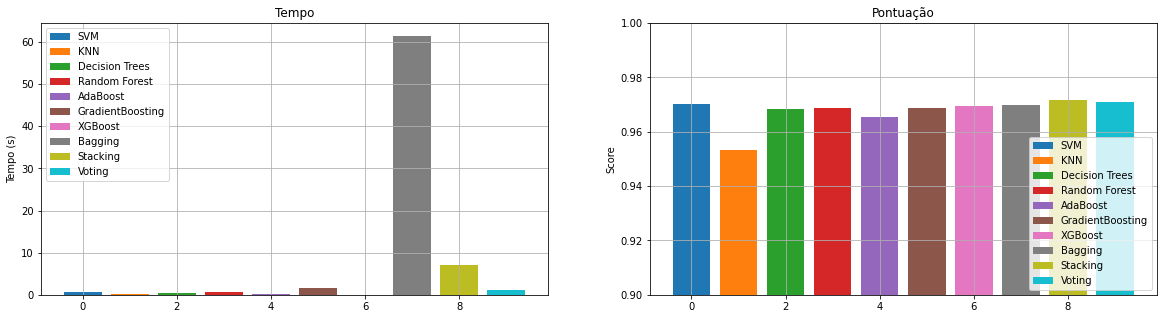

In [139]:
fig, ax = plt.subplots(nrows=1, ncols = 2, figsize=(20, 5))
for i in range (len(time_ex)):
    ax[0].bar(i, time_ex[i], label=models[i])
    ax[1].bar(i, score[i], label=models[i])

ax[0].legend()
ax[0].set_title('Tempo')
ax[0].set_ylabel('Tempo (s)')
ax[0].grid()

ax[1].legend(loc='lower right')
ax[1].set_title('Pontuação')
ax[1].set_ylim(0.9, 1)
ax[1].set_ylabel('Score')
ax[1].grid()

plt.show()

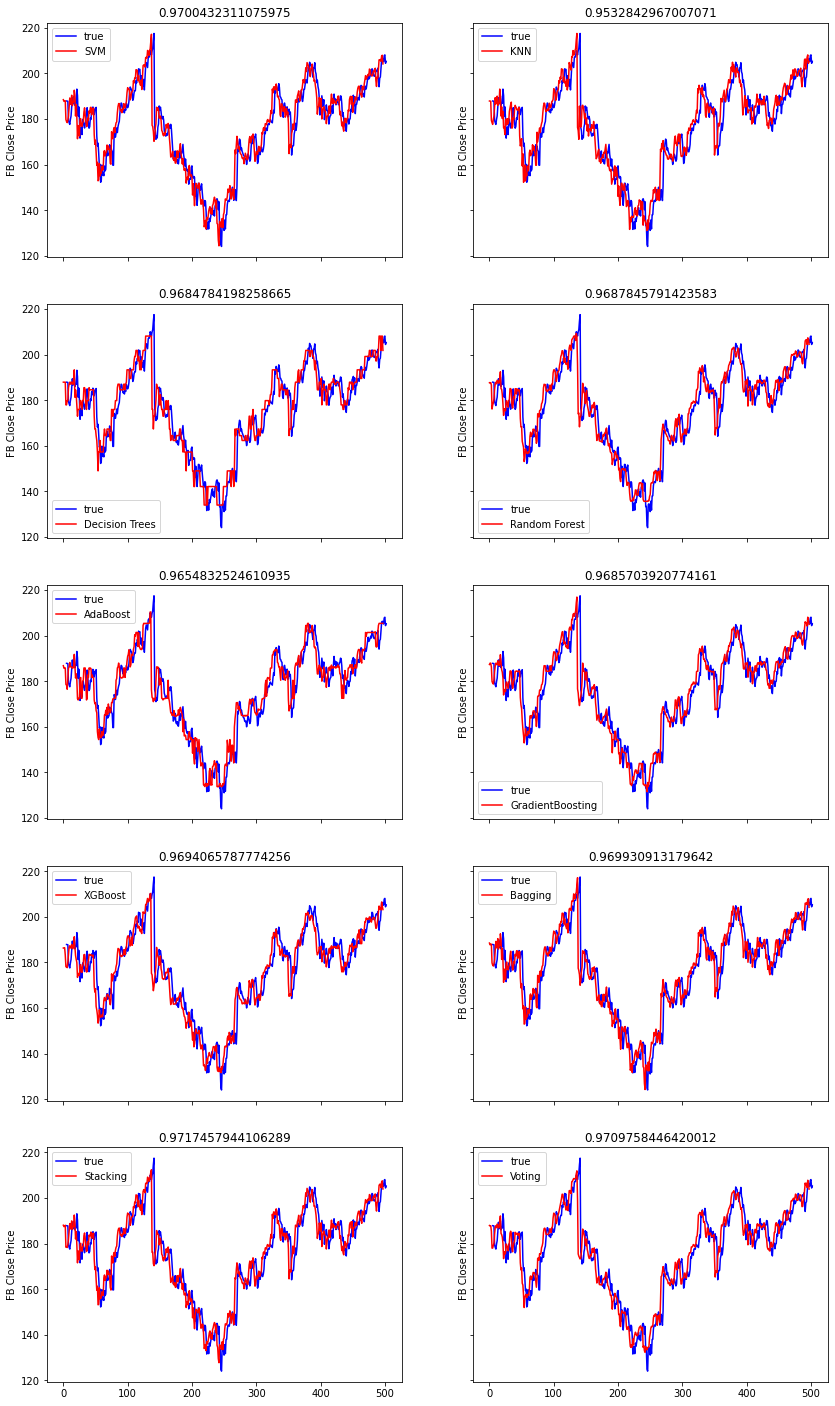

In [152]:
mdl = [svr, knn, tree, rf, adb, gb, xgb, bag, stk, vot]

fig, ax = plt.subplots(nrows = 5, ncols = 2, sharey = True, sharex = True, figsize=(14,25))

l, c = 0, 0

for i,m in enumerate(mdl):
    pred = m.predict(X)
    ax[l][c].plot(y, color='blue', label='true')
    ax[l][c].plot(pred, color='red', label = models[i])
    
    ax[l][c].legend()
    ax[l][c].set_ylabel("FB Close Price")
    ax[l][c].set_title(score[i])
    
    c += 1
    if c == 2:
        c = 0
        l +=1